# Lab 3: Policy Search
Solution written by Serra Matteo and Matteo Magnaldi.

In [1]:
import logging
#from minmax import *
from agent import *
from nim import Nim
from utility import play, run_benchmark, nim_sum
import random
from typing import Callable
from expert_strategy import ExpertSystem, System
from evo_rule_strategy import EvolvedRulesAgent, cook_status
from minmax import MinMaxAgent

import os
logging.getLogger().setLevel(logging.INFO)


### Expert System

In [11]:
NIM_DIM = 4
BENCHMARK_ITER = 10_000
#test on the expert system
win_rate = run_benchmark(BENCHMARK_ITER,NIM_DIM,ExpertSystem.next_move, System.random_move)
logging.info(f"Winning rate: expert system vs random system: {win_rate}")
win_rate = run_benchmark(BENCHMARK_ITER,NIM_DIM,System.random_move,System.random_move)
logging.info(f"Winning rate: random system vs random system: {win_rate}")
win_rate = run_benchmark(BENCHMARK_ITER,NIM_DIM,ExpertSystem.next_move,ExpertSystem.next_move)
logging.info(f"Winning rate: expert system vs expert system: {win_rate}")


INFO:root:Winning rate: expert system vs random system: 100.0
INFO:root:Winning rate: random system vs random system: 30.0
INFO:root:Winning rate: expert system vs expert system: 40.0


### Evolved Rules Agent

In [3]:

NUM_GENERATIONS = 100
POPULATION_SIZE = 30
NUM_ITER = 200
NUM_ROUND = 200
NUM_COOK_STATUS = 8



In [12]:
train = False
dump_path = f'./data/evolved_agent.data-{NIM_DIM}'

evolved_agent = EvolvedRulesAgent(NUM_GENERATIONS, NIM_DIM, NUM_ITER, NUM_ROUND, NUM_COOK_STATUS, pop_size=POPULATION_SIZE)

if os.path.isfile(dump_path) and not train:
    evolved_agent = EvolvedRulesAgent.from_file(dump_path)
else:
    evolved_agent.train()
    evolved_agent.dump(dump_path)



In [5]:
win_rate = run_benchmark(BENCHMARK_ITER, NIM_DIM, evolved_agent.next_move, ExpertSystem.next_move)
logging.info(f"Winning rate: first evolved agent vs expert system: {win_rate}")

win_rate = run_benchmark(BENCHMARK_ITER, NIM_DIM, evolved_agent.next_move, System.random_move)
logging.info(f"Winning rate: first evolved agent vs random system: {win_rate}")


INFO:root:Winning rate: first evolved agent vs expert system: 0.95
INFO:root:Winning rate: first evolved agent vs random system: 50.449999999999996


### Second Evolved Rules System

In [6]:
Q = 0.01
NUM_ROUND = 1000
NUM_ITER = 1000

train = False
dump_path = f'./data/er_agent.data-{NIM_DIM}'

er_agent = EvolvedRulesAgent(NUM_GENERATIONS, NIM_DIM, NUM_ITER, NUM_ROUND, NUM_COOK_STATUS, q=Q)

if os.path.isfile(dump_path) and not train:
    er_agent = EvolvedRulesAgent.from_file(dump_path)
else:
    er_agent.train_with_rewards()
    er_agent.dump(dump_path)

In [7]:
win_rate = run_benchmark(BENCHMARK_ITER, NIM_DIM, er_agent.next_move, ExpertSystem.next_move)
logging.info(f"Winning rate: first evolved agent vs expert system: {win_rate}")

win_rate = run_benchmark(BENCHMARK_ITER, NIM_DIM, er_agent.next_move, System.random_move)
logging.info(f"Winning rate: first evolved agent vs random system: {win_rate}")

INFO:root:Winning rate: first evolved agent vs expert system: 0.2
INFO:root:Winning rate: first evolved agent vs random system: 51.0


### MinMax Agent

In [8]:
minmax_agent = MinMaxAgent()
win_rate = run_benchmark(BENCHMARK_ITER, NIM_DIM, minmax_agent.next_move, System.random_move)
logging.info(f"Winning rate minmax vs random_move: {win_rate}")
win_rate = run_benchmark(BENCHMARK_ITER, NIM_DIM, minmax_agent.next_move, ExpertSystem.next_move)
logging.info(f"Winning rate minmax vs expert system: {win_rate}")


INFO:root:Winning rate minmax vs random_move: 100.0
INFO:root:Winning rate minmax vs expert system: 49.72


### Reinforcement Learning Agent

In [18]:

NUM_ROUND = BENCHMARK_ITER
nim = Nim(NIM_DIM)

train = False
dump_path = f'./data/RL_agent.data-{NIM_DIM}'

rl_agent = RLAgent(nim._rows, alpha=0.03, random_factor=0.3)

if not train and os.path.isfile(dump_path):
    rl_agent = RLAgent.from_file(dump_path)
else:
    rl_agent.train(NIM_DIM, NUM_ROUND, show_epoch_results= True)
    rl_agent.dump(dump_path)




4


In [16]:
rl_agent.random_factor = 0
win_rate = run_benchmark(BENCHMARK_ITER, NIM_DIM, rl_agent.choose_action, ExpertSystem.next_move)
logging.info(f"Winning rate RL agent vs expert system: {win_rate} %")


KeyError: (0, 3, 4, 7)

In [ ]:
def human_player(nim:Nim):
    print(f"board: {nim._rows}")
    move = input(f"inserisci la mossa(row,k)")
    row,k = move.split(',')
    nim.niming(int(row),int(k))
    #return int(row),int(k)




### Alternative Version
Part of the code is taken from https://cs50.harvard.edu/extension/ai/2020/spring/projects/4/nim/ but much of the "intelligence" is written by us.

In [ ]:
from nim_oxford import train, play

def _make_strategy(ai):
    def strategy(nim: Nim):
        return ai.choose_action(nim._rows)
    return strategy

alphas = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
epsilons = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

win_ratios = []
for alpha in alphas:
    for epsilon in epsilons:
        ai = train(BENCHMARK_ITER, NIM_DIM, alpha=alpha, espilon=epsilon)
        rl_strategy = _make_strategy(ai)
        win_ratio = run_benchmark(BENCHMARK_ITER, NIM_DIM, rl_strategy, ExpertSystem.next_move)
        win_ratios.append(((alpha, epsilon), win_ratio))


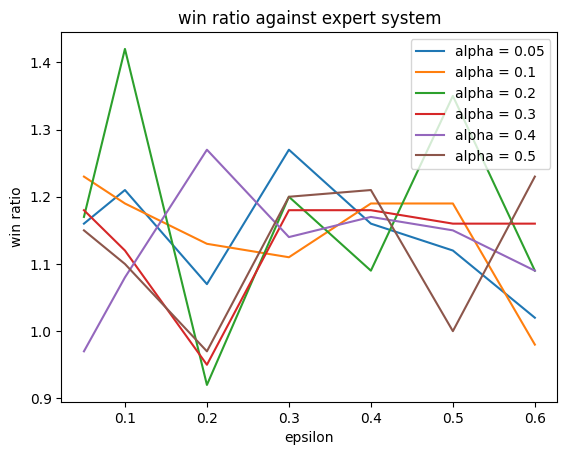

In [ ]:
from matplotlib import pyplot as plt
win_ratios

for alpha in alphas:
    
    x = [w[0][1] for w in win_ratios if w[0][0] == alpha]
    y = [w[1] for w in win_ratios if w[0][0] == alpha]
    plt.plot(x, y, label=f"alpha = {alpha}")
plt.xlabel("epsilon")
plt.ylabel("win ratio")
plt.title("win ratio against expert system")
plt.legend()
plt.show()

(alpha, epsilon) = max(win_ratios, key= lambda w : w[1])[0]
ai = train(BENCHMARK_ITER, NIM_DIM, alpha=alpha, espilon=epsilon)
        


In [ ]:
from tqdm import trange, tqdm
N_ITER = 10_000
agents = {"random" : System.random_move,
          "expert": ExpertSystem.next_move,
          "evolved_rule_1": evolved_agent.next_move,
          "evolved_rule_2": er_agent.next_move,
          "min_max": minmax_agent.next_move,
          "rl_agent": rl_agent.choose_action,
          "rl_oxford": rl_strategy}
colors = ["orange", "orangered", "lightpink", "orchid", "darkviolet", "indigo", "steelblue"]
labels = list(agents.keys())
width = 0.7

fig, ax = plt.subplots(figsize=(12, 6))

x = numpy.arange(len(labels)) 
all_wrs = []
for name, agent in tqdm(agents.items()):
    wrs = []
    for opponent_name, opponent in agents.items():
        
        wr = run_benchmark(N_ITER, NIM_DIM, agent, opponent)
        wrs.append(wr)
    all_wrs.append(wrs)
all_wrs = numpy.array(all_wrs).T
for i, wrs, color in zip([3, 2, 1, 0, -1, -2, -3], all_wrs, colors):
    offset = i * width/7
    plt.bar(x-offset , wrs, width/7, color=color)

plt.xticks(x, labels)
plt.xlabel("Agents")
plt.ylabel("Win rate (%)")
plt.legend(labels)
plt.show()


NameError: name 'System' is not defined